In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.head()

,time,count_a,count_b
0,365,7,5
1,364,4,3
2,363,3,1
3,362,4,3
4,361,6,2


In [6]:
count_data_a = np.array(data['count_a'])
count_data_b = np.array(data['count_b'])
count_data = np.concatenate((count_data_a,count_data_b))
time = np.array(data['time'])
n_count_data = len(time)

In [7]:
log_time = np.log(time+1)
log_time = log_time - log_time.mean()

(0, 366)

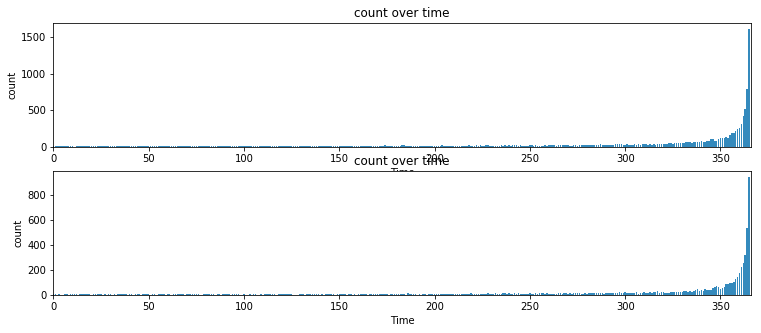

In [8]:
figsize(12.5, 5)

ax = plt.subplot(211)
plt.bar(np.arange(n_count_data), count_data_a, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count")
plt.title("count over time")
plt.xlim(0, n_count_data)

ax = plt.subplot(212)
plt.bar(np.arange(n_count_data), count_data_b, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count")
plt.title("count over time")
plt.xlim(0, n_count_data)

In [9]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_a = pm.Exponential("lambda_a", alpha)
    lambda_b = pm.Exponential("lambda_b", alpha)
    
    count_a = pm.Poisson("count_a", lambda_a, observed=count_data_a)
    count_b = pm.Poisson("count_b", lambda_b, observed=count_data_b)

In [10]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_b, lambda_a]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:07<00:00, 2707.43draws/s]


In [11]:
lambda_a_samples = trace['lambda_a']
lambda_b_samples = trace['lambda_b']
print(lambda_a_samples.mean())
print(lambda_b_samples.mean())

29.231095549924813
17.705989538626092


Text(0.5, 0, '$\\lambda_2$ value')

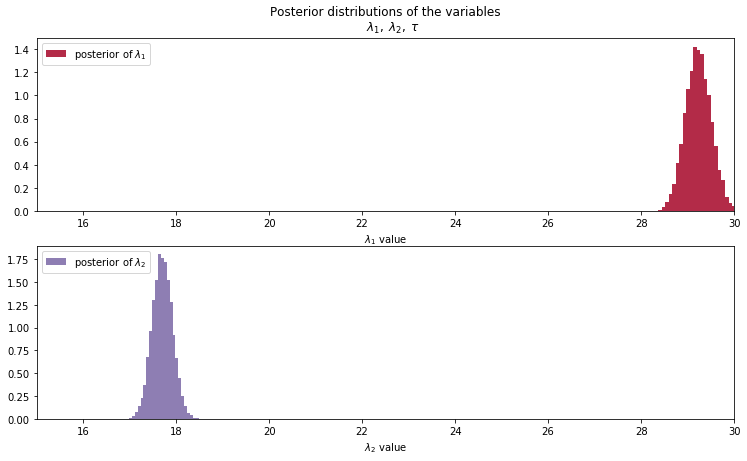

In [13]:
figsize(12.5, 7)

ax = plt.subplot(211)
ax.set_autoscaley_on(True)
plt.hist(lambda_a_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(212)
ax.set_autoscaley_on(True)
plt.hist(lambda_b_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

In [16]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_a = pm.Normal('beta_a', mu=0, sd=10)
    beta_b = pm.Normal('beta_b', mu=0, sd=10)

    # define linear model and exp link function
    theta_a = (alpha + beta_a * log_time)
    theta_b = (alpha + beta_b * log_time)

    ## Define Poisson likelihood
    count_a = pm.Poisson('count_a', mu=np.exp(theta_a), observed=count_data_a)
    count_b = pm.Poisson('count_b', mu=np.exp(theta_b), observed=count_data_b)
    

In [17]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_b, beta_a, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:11<00:00, 1781.95draws/s]
The acceptance probability does not match the target. It is 0.8836010525986141, but should be close to 0.8. Try to increase the number of tuning steps.


In [18]:
alpha_samples = trace['alpha']
beta_a_samples = trace['beta_a']
beta_b_samples = trace['beta_b']
print(alpha_samples.mean())
print(beta_a_samples.mean())
print(beta_b_samples.mean())

2.303661878690963
-1.046301544942857
-0.9121239647994965


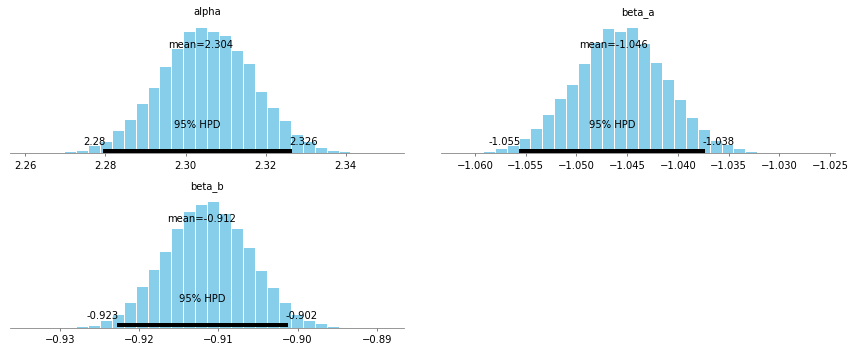

In [19]:
pm.posteriorplot.plot_posterior(trace, varnames = ['alpha', 'beta_a', 'beta_b']);

In [20]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    alpha_a = pm.Normal('alpha_a', mu=0, sd=10)
    alpha_b = pm.Normal('alpha_b', mu=0, sd=10)
    
    beta = pm.Normal('beta', mu=0, sd=10)

    # define linear model and exp link function
    theta_a = (alpha_a + beta * log_time)
    theta_b = (alpha_b + beta * log_time)

    ## Define Poisson likelihood
    count_a = pm.Poisson('count_a', mu=np.exp(theta_a), observed=count_data_a)
    count_b = pm.Poisson('count_b', mu=np.exp(theta_b), observed=count_data_b)
    

In [21]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha_b, alpha_a]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:12<00:00, 1739.25draws/s]


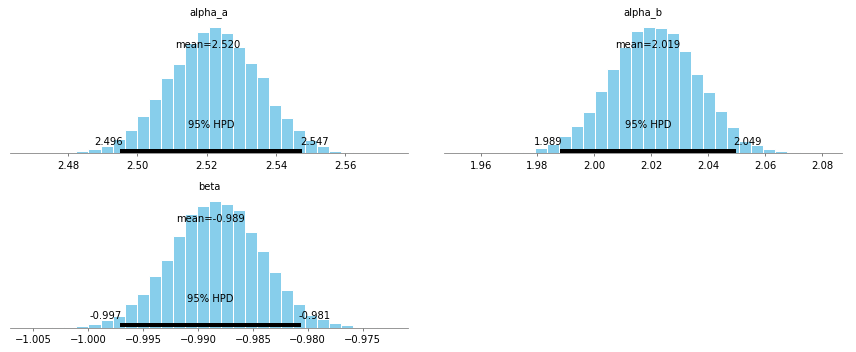

In [22]:
pm.posteriorplot.plot_posterior(trace, varnames = ['alpha_a', 'alpha_b', 'beta']);

In [23]:
alpha_a_samples = trace['alpha_a']
alpha_b_samples = trace['alpha_b']
beta_samples = trace['beta']
print(alpha_a_samples.mean())
print(alpha_b_samples.mean())
print(beta_samples.mean())

2.5203478528990066
2.0188397262444147
-0.9888792217349184


In [24]:
print(np.exp(alpha_a_samples.mean()))
print(np.exp(alpha_b_samples.mean()))
print(beta_samples.mean())

12.432920738985034
7.529583485297551
-0.9888792217349184


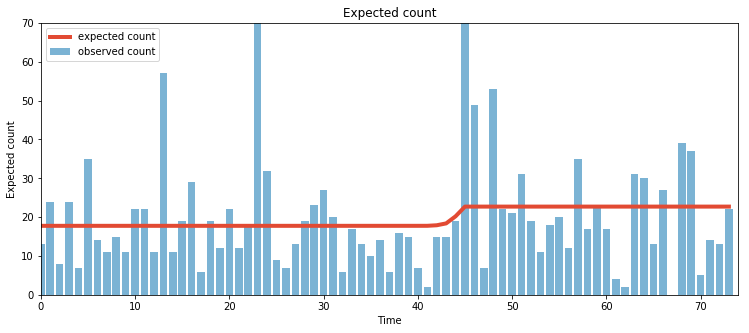

In [72]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_count = np.zeros(n_count_data)
for t in range(0, n_count_data):
    ix = t < tau_samples
    expected_count[t] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_count, lw=4, color="#E24A33",
         label="expected count")
plt.xlim(0, n_count_data)
plt.xlabel("Time")
plt.ylabel("Expected count")
plt.title("Expected count")
plt.ylim(0, 70)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed count")

plt.legend(loc="upper left");

Text(0.5, 0, 'count data')

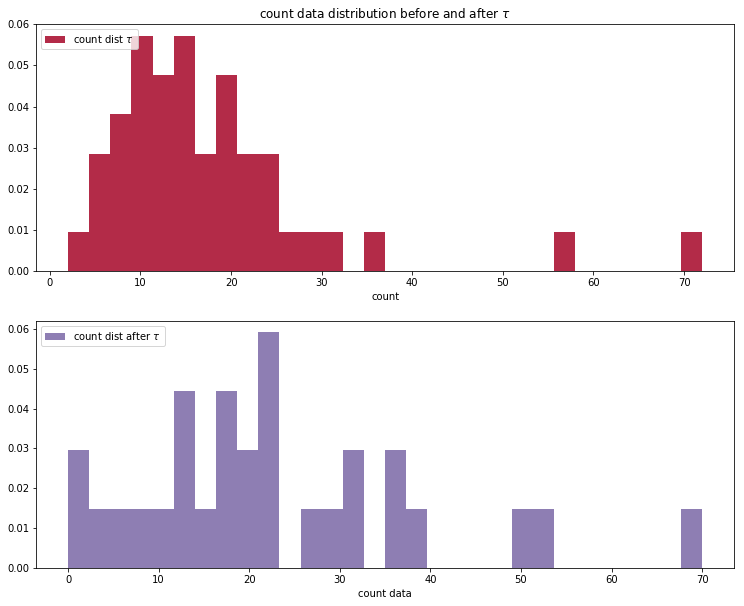

In [73]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(211)

plt.hist(count_data[:tau_mode], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist $\tau$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""count data distribution before and after $\tau$""")
plt.xlabel("count")

ax = plt.subplot(212)
plt.hist(count_data[tau_mode:], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist after $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlabel("count data")